# Statistical forecasting with ARIMA

In [1]:

from modules import utils
utils.configure_plotly_template(showlegend=True)

## Load data

In [2]:
path = '../../../data/statsmodels/AirPassengers_log.parquet'

In [3]:
import pandas as pd

df = pd.read_parquet(path).asfreq('ME')
df.columns = ["values"]
series = df["values"]
series

1949-01-31    4.718499
1949-02-28    4.770685
                ...   
1960-11-30    5.966147
1960-12-31    6.068426
Freq: ME, Name: values, Length: 144, dtype: float64

In [4]:
series.plot()

## Model fit

In [5]:
from statsmodels.tsa.arima.model import ARIMA

In [6]:
p = 12
d = 1
q = 2

model = ARIMA(series, order=(p, d, q))
model_fit = model.fit()

model_fit.summary()

/Users/sota/miniforge3/envs/work/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 values   No. Observations:                  144
Model:                ARIMA(12, 1, 2)   Log Likelihood                 246.818
Date:                Tue, 20 May 2025   AIC                           -463.636
Time:                        11:25:18   BIC                           -419.194
Sample:                    01-31-1949   HQIC                          -445.577
                         - 12-31-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1066      0.065      1.651      0.099      -0.020       0.233
ar.L2         -0.0773      0.069     -1.117      0.264      -0.213       0.058
ar.L3          0.0039      0.051      0.076      0.939      -0.095       0.103
ar.L4         -0.0613      0.053     -1.156      0.248      -0.165       0.043
ar.L5          0.0506      0.052      0.967      0.334      -0.052       0.153
ar.L6         -0.0479      0.047     -1.019      0.308      -0.140       0.044
ar.L7         -0.0111      0.051     -0.216      0.829      -0.111       0.089
ar.L8         -0.0994      0.053     -1.892      0.059      -0.202       0.004
ar.L9          0.0677      0.059      1.155      0.248      -0.047       0.182
ar.L10        -0.0681      0.057     -1.204      0.229      -0.179       0.043
ar.L11         0.0531      0.052      1.025      0.306      -0.048       0.155
ar.L12         0.8312      0.054     15.258      0.000       0.724       0.938
ma.L1         -0.4404      0.100     -4.398      0.000      -0.637      -0.244
ma.L2          0.0601      0.107      0.563      0.574      -0.149       0.269
sigma2         0.0016      0.000      7.774      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 3.11
Prob(Q):                              0.87   Prob(JB):                         0.21
Heteroskedasticity (H):               0.50   Skew:                             0.35
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecast

In [7]:
HORIZON = 48

forecast = model_fit.forecast(steps=HORIZON)
forecast

1961-01-31    6.112831
1961-02-28    6.038083
                ...   
1964-11-30    6.174416
1964-12-31    6.215497
Freq: ME, Name: predicted_mean, Length: 48, dtype: float64

In [8]:
df_pred = series.to_frame()
df_pred

,values
1949-01-31,4.718499
1949-02-28,4.770685
...,...
1960-11-30,5.966147
1960-12-31,6.068426


In [9]:
df_forecast = forecast.to_frame(name='forecast')
df_pred = pd.concat([df_pred, df_forecast])
df_pred

,values,forecast
1949-01-31,4.718499,NaN
1949-02-28,4.770685,NaN
...,...,...
1964-11-30,NaN,6.174416
1964-12-31,NaN,6.215497


In [10]:
df_pred.plot(color='variable')

## Configuration

```python
p = 12
d = 1
q = 2

model = ARIMA(series, order=(p, d, q))
```

| Parameter | Name                     | What it does                                                                   |
| --------- | ------------------------ | ------------------------------------------------------------------------------ |
| p         | AR (AutoRegressive) part | How many *lagged values* of the time series are used (past observations).      |
| d         | I (Integrated) part      | How many times we difference the data to make it stationary.                   |
| q         | MA (Moving Average) part | How many lagged *forecast errors* (residuals) are used to model the next step. |

Why?

### q: Differencing

- ARIMA assumes that the series is stationary.
- Stationary series have constant mean and variance over time.

In [11]:
series.plot()

In [12]:
df = series.to_frame()
df['values_diff'] = df['values'].diff()
df

,values,values_diff
1949-01-31,4.718499,NaN
1949-02-28,4.770685,0.052186
...,...,...
1960-11-30,5.966147,-0.167251
1960-12-31,6.068426,0.102279


In [13]:
df = df.dropna()
df

,values,values_diff
1949-02-28,4.770685,0.052186
1949-03-31,4.882802,0.112117
...,...,...
1960-11-30,5.966147,-0.167251
1960-12-31,6.068426,0.102279


In [14]:
fig = df.plot(facet_col='variable')
fig.update_yaxes(matches=None)

In [15]:
from statsmodels.tsa.stattools import adfuller

$$
\begin{cases}
H_0: \text{The series has a unit root (non-stationary)} \\
H_1: \text{The series is stationary}
\end{cases}
$$

In [16]:
adfuller(df['values'], maxlag=12)

(np.float64(-1.8549921957299633),
 np.float64(0.35352116777129644),
 12,
 130,
 {'1%': np.float64(-3.4816817173418295),
  '5%': np.float64(-2.8840418343195267),
  '10%': np.float64(-2.578770059171598)},
 np.float64(-440.29474279152817))

In [17]:
adfuller(df['values_diff'], maxlag=12)

(np.float64(-3.0530320109154414),
 np.float64(0.030229987648698397),
 12,
 130,
 {'1%': np.float64(-3.4816817173418295),
  '5%': np.float64(-2.8840418343195267),
  '10%': np.float64(-2.578770059171598)},
 np.float64(-448.718127711991))

### `p`: PACF – Partial Autocorrelation Function

* PACF is the **partial autocorrelation** of the series.
* It measures the correlation of the series with its past values, **controlling for the influence of intermediate lags**.
* Use PACF to determine the **AR (AutoRegressive)** component **`p`** in ARIMA.

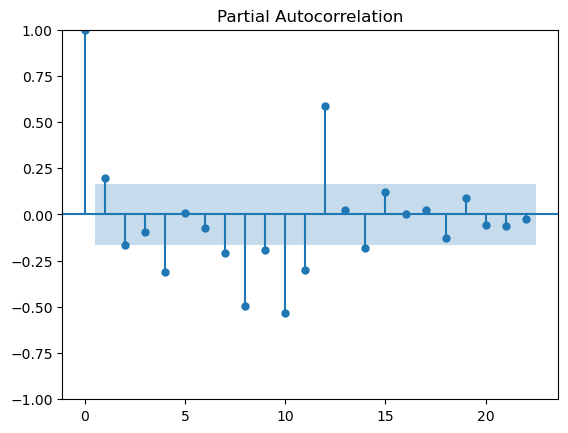

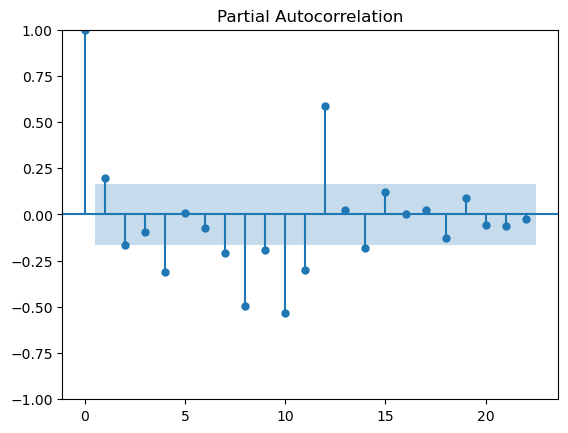

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['values_diff'])

### `q`: ACF – Autocorrelation Function

* ACF is the **autocorrelation** of the series.
* It measures the correlation of the series with its past values **without controlling** for intermediate lags.
* Use ACF to determine the **MA (Moving Average)** component **`q`** in ARIMA.

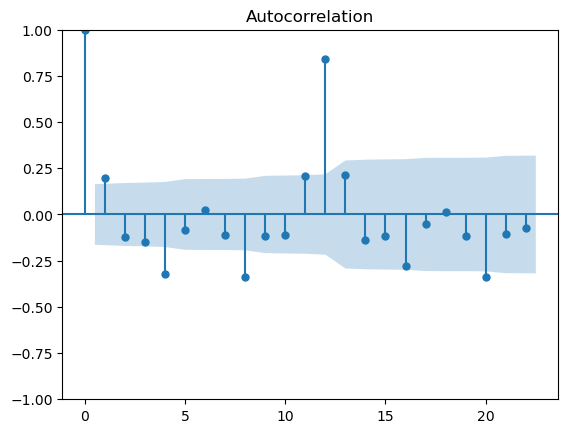

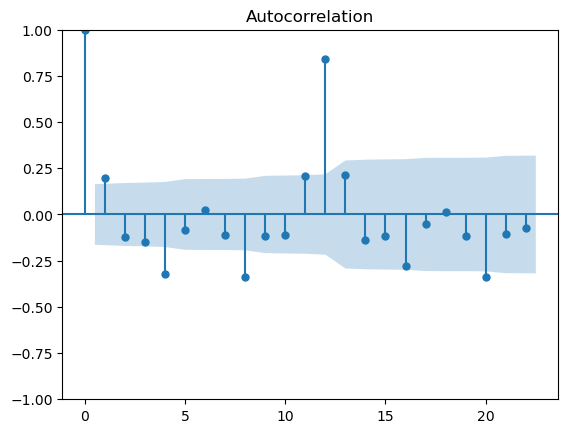

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['values_diff'])

## Variation playground

In [20]:
from modules import utils

In [21]:
df = df[['values']]
df_forecast = utils.get_model_forecast(df, 'values', order=(12, 1, 2))
df_forecast

/Users/sota/miniforge3/envs/work/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,values,"ARIMA(12,1,2)"
1949-02-28,4.770685,NaN
1949-03-31,4.882802,NaN
...,...,...
1964-11-30,NaN,6.164890
1964-12-31,NaN,6.210199


In [22]:
df_forecast.plot(color='variable')

In [23]:
df_forecast = utils.get_model_forecast(df_forecast, "values", order=(12, 1, 1))
df_forecast.plot(color='variable')

/Users/sota/miniforge3/envs/work/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [24]:
df_forecast = utils.get_model_forecast(df_forecast, "values", order=(12, 0, 1))
df_forecast.plot(color='variable')

/Users/sota/miniforge3/envs/work/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/sota/miniforge3/envs/work/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



## Diagnostics and assumptions

In [25]:
model = ARIMA(series, order=(12, 1, 2))
model_fit = model.fit()
model_fit.summary()

/Users/sota/miniforge3/envs/work/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 values   No. Observations:                  144
Model:                ARIMA(12, 1, 2)   Log Likelihood                 246.818
Date:                Tue, 20 May 2025   AIC                           -463.636
Time:                        11:25:20   BIC                           -419.194
Sample:                    01-31-1949   HQIC                          -445.577
                         - 12-31-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1066      0.065      1.651      0.099      -0.020       0.233
ar.L2         -0.0773      0.069     -1.117      0.264      -0.213       0.058
ar.L3          0.0039      0.051      0.076      0.939      -0.095       0.103
ar.L4         -0.0613      0.053     -1.156      0.248      -0.165       0.043
ar.L5          0.0506      0.052      0.967      0.334      -0.052       0.153
ar.L6         -0.0479      0.047     -1.019      0.308      -0.140       0.044
ar.L7         -0.0111      0.051     -0.216      0.829      -0.111       0.089
ar.L8         -0.0994      0.053     -1.892      0.059      -0.202       0.004
ar.L9          0.0677      0.059      1.155      0.248      -0.047       0.182
ar.L10        -0.0681      0.057     -1.204      0.229      -0.179       0.043
ar.L11         0.0531      0.052      1.025      0.306      -0.048       0.155
ar.L12         0.8312      0.054     15.258      0.000       0.724       0.938
ma.L1         -0.4404      0.100     -4.398      0.000      -0.637      -0.244
ma.L2          0.0601      0.107      0.563      0.574      -0.149       0.269
sigma2         0.0016      0.000      7.774      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 3.11
Prob(Q):                              0.87   Prob(JB):                         0.21
Heteroskedasticity (H):               0.50   Skew:                             0.35
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
residuals = model_fit.resid[1:]

### Autocorrelation

#### Plot

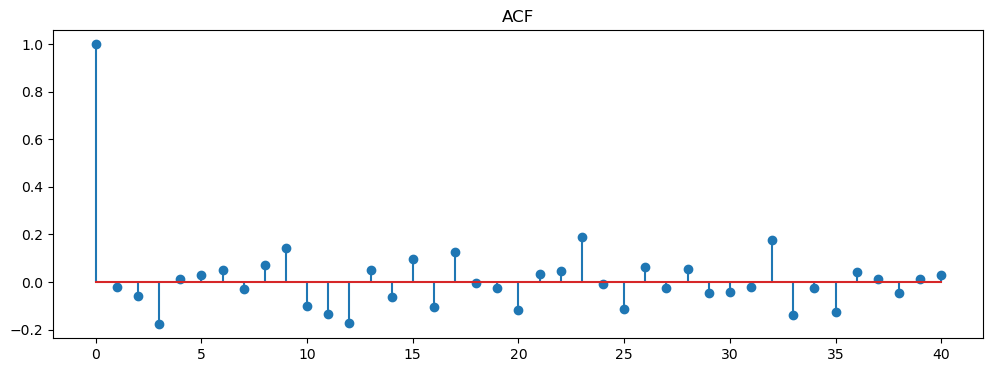

In [27]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

lags = 40
acf = acf(residuals, nlags=lags)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.stem(range(lags + 1), acf)
ax.set_title("ACF")
plt.show()


#### Test

In [28]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box Test:\n", lb)

Ljung-Box Test:
       lb_stat  lb_pvalue
10  11.435226   0.324630
20  28.337822   0.101641
30  39.328977   0.118528


### Normality

#### Plot

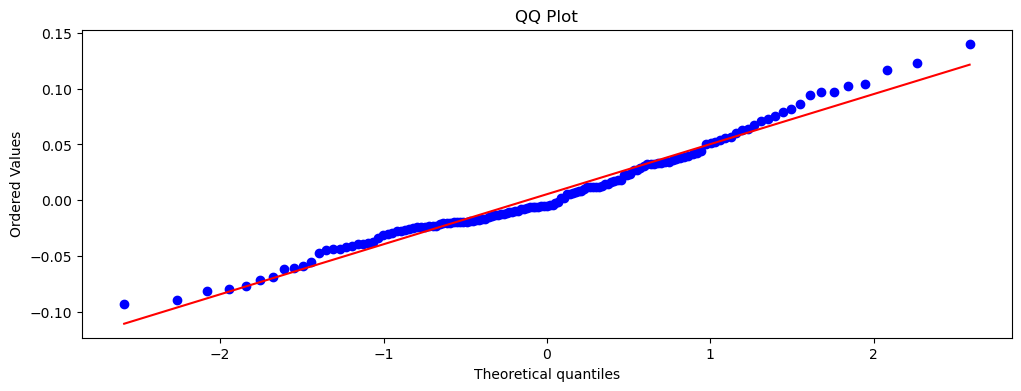

In [29]:
from scipy import stats

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("QQ Plot")
plt.show()

#### Test

In [30]:
from scipy.stats import jarque_bera

jb = jarque_bera(residuals)

print(
    f"Jarque-Bera (Good): Statistic={jb.statistic:.3f}, p-value={jb.pvalue:.3f}"
)

Jarque-Bera (Good): Statistic=6.464, p-value=0.039


### Homoscedasticity

#### Plot

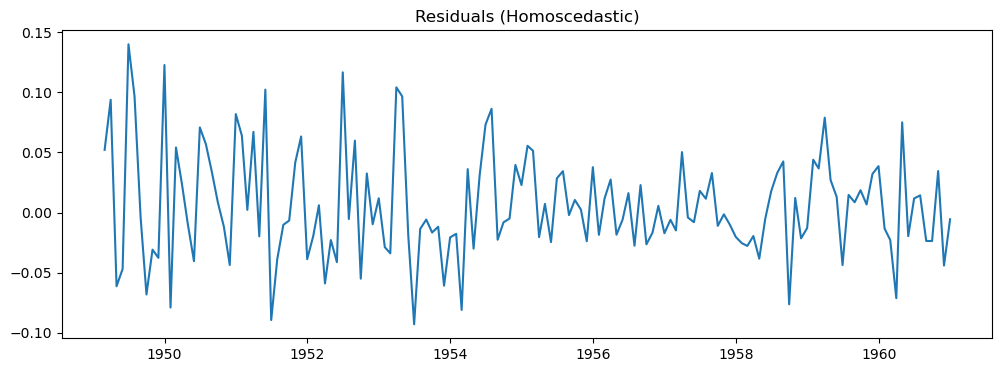

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(residuals)
ax.set_title("Residuals (Homoscedastic)")
plt.show()

#### Test

In [32]:
from statsmodels.stats.diagnostic import het_arch
arch = het_arch(residuals)

print(f"ARCH Test: LM Stat={arch[0]:.3f}, p-value={arch[1]:.3f}")

ARCH Test: LM Stat=25.653, p-value=0.004
